In [5]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
data = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.QCD_B_List), Tree(fc.eightb.preselection_ranked_quadh.TTJets)])
signal = ObjIter([Tree(fn) for fn in fc.eightb.preselection_ranked_quadh.signal_list[::3]])

In [8]:
(signal+data).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))
(signal+data).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'bjet', ptordered=True))

[None, None, None, None, None]

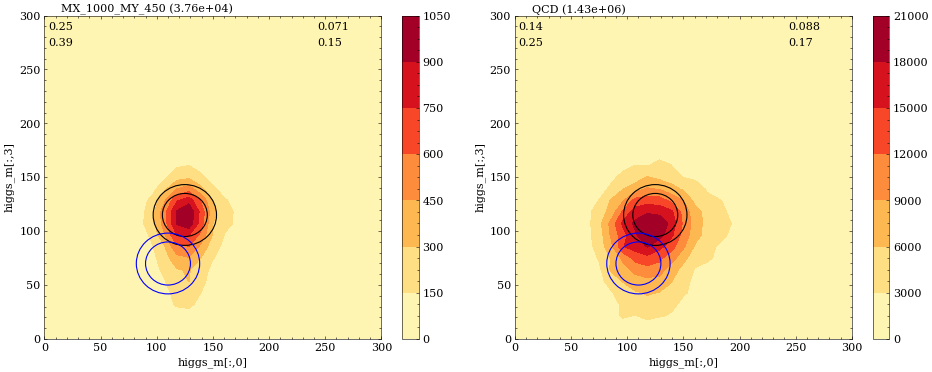

In [9]:
study.quick2d_region(
  signal[[-1]], data,
  varlist=['higgs_m[:,0]','higgs_m[:,3]'],
  contour=True,
  # exe=[draw_ellipse(125,115,15,25)]
  exe=[draw_circle(125,115,20), 
       draw_circle(125,115,1.41*20, text=(0,0.95)),
       draw_circle(110, 70,20, color='b', text=(0.8,1)), 
       draw_circle(110, 70,1.41*20, text=(0.8,0.95), color='b')]
)

In [10]:
def preprocess(tree):
  h_dm = np.sqrt((tree.higgs_m[:,0]-125)**2 + (tree.higgs_m[:,3]-115)**2)
  n_medium_btag = ak.sum( tree.bjet_btag>jet_btagWP[2], axis=-1)
  tree.extend(h_dm=h_dm,n_medium_btag=n_medium_btag)
(signal+data).apply(preprocess)

[None, None, None, None, None]

In [11]:
rs = {"a":lambda t : (t.n_medium_btag >= 4) & (t.h_dm >  0) & (t.h_dm < 20),
      "b":lambda t : (t.n_medium_btag <  4) & (t.h_dm >  0) & (t.h_dm < 20),
      "c":lambda t : (t.n_medium_btag >= 4) & (t.h_dm > 20) & (t.h_dm < 1.41*20) ,
      "d":lambda t : (t.n_medium_btag <  4) & (t.h_dm > 20) & (t.h_dm < 1.41*20) ,}

In [12]:
varinfo.h_dm = dict(bins=(0,100,30))
varinfo.n_medium_btag = dict(bins=np.arange(10))

100%|██████████| 2/2 [00:12<00:00,  6.29s/it]


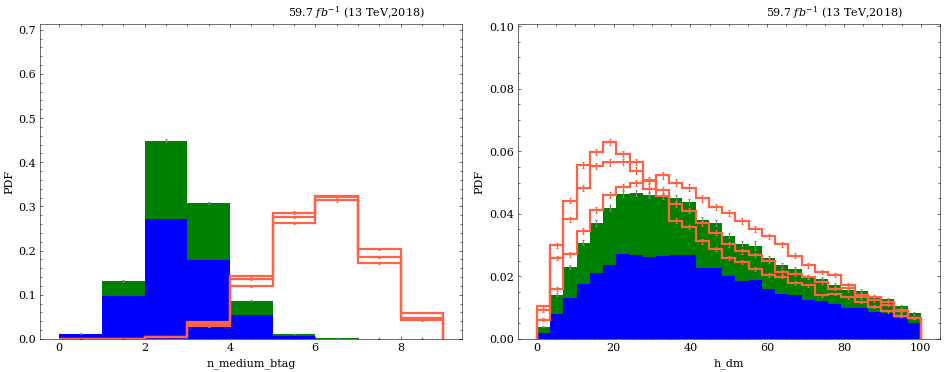

In [13]:
study.quick(
  data+signal, efficiency=True, stacked=True,
  varlist=['n_medium_btag','h_dm']
)

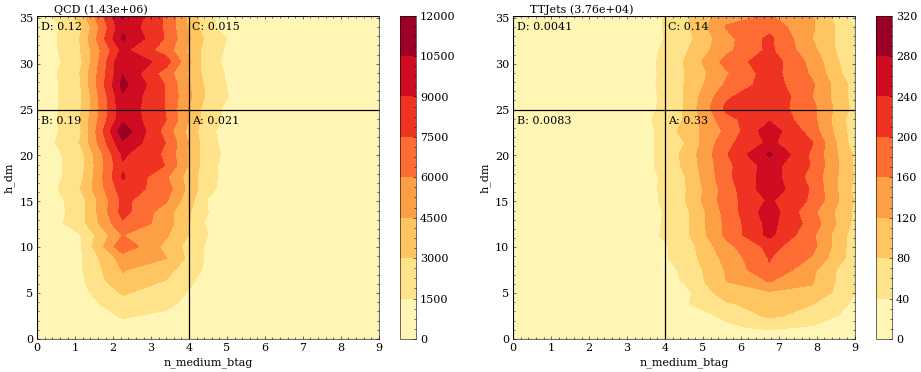

In [14]:
x_r, y_r = (0,4,9),(0,25,1.41*25)

study.quick2d_region(
  data, signal[[-1]], stacked=True,
  varlist=['n_medium_btag','h_dm'],
  binlist=[None,(0,y_r[-1],30)],
  # h_restrict=True,
  contour=True,
  exe=draw_abcd(x_r, y_r, swapy=True)
)

In [15]:
feature_names = [
    f'{obj}_m'
    for obj in ['X']+eightb.ylist+eightb.higgslist
]

In [16]:
abcd = ABCD(feature_names, **rs)

100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


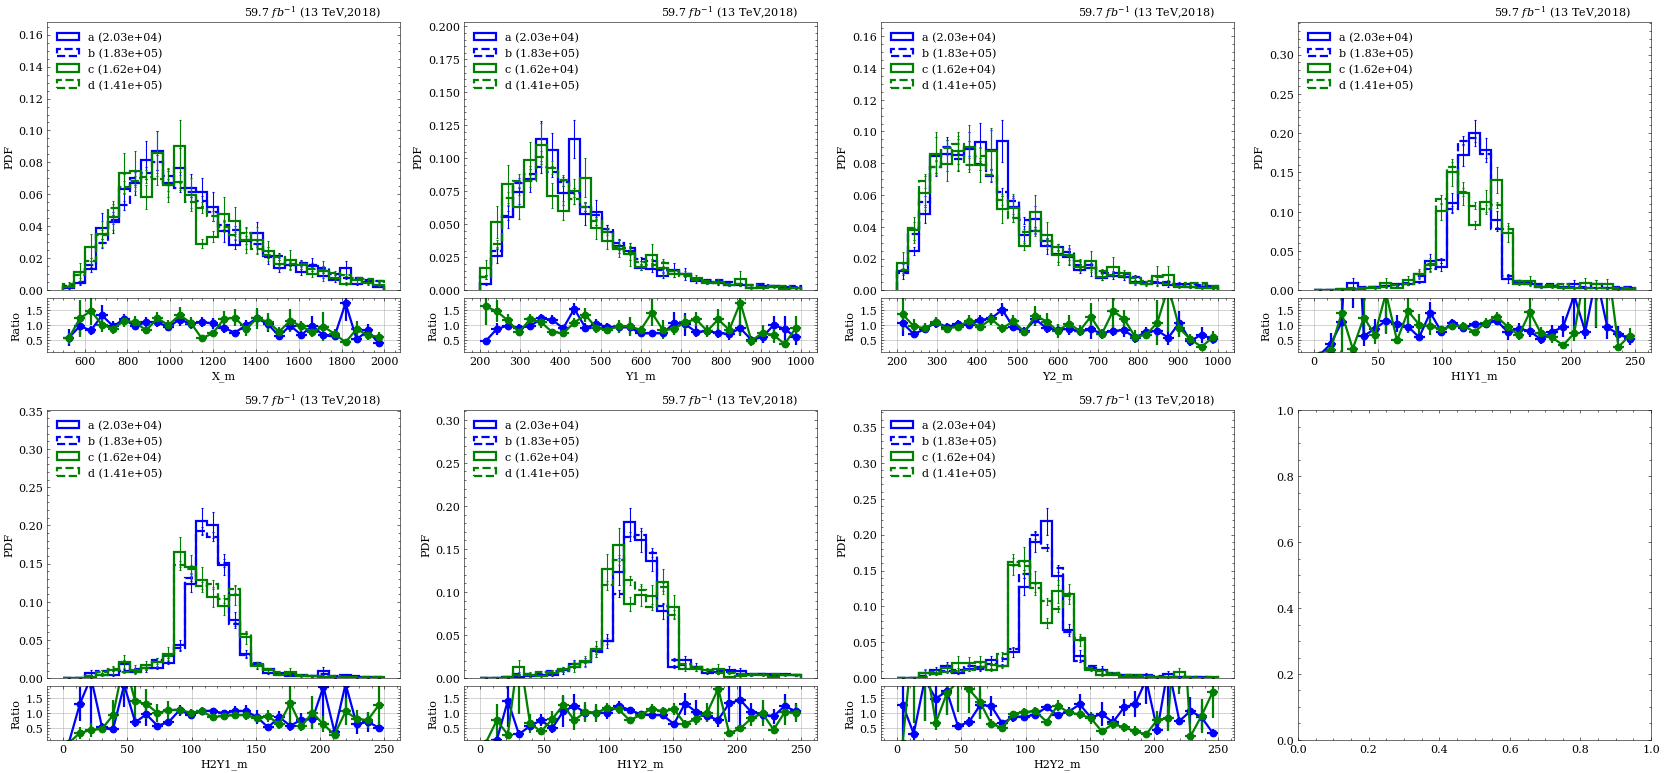

In [27]:
study.quick_region(
  data, data, data, data, efficiency=True,
  label=list(rs.keys()),
  h_color=['b']*2+['g']*2,
  h_linestyle=[None,'--']*2,
  legend=True,
  varlist=feature_names,
  masks=[abcd.a]*len(data)+[abcd.b]*len(data)+[abcd.c]*len(data)+[abcd.d]*len(data),

  ratio=True, r_group=[(0,1),(2,3)]
)

In [18]:
abcd.train(data)

100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


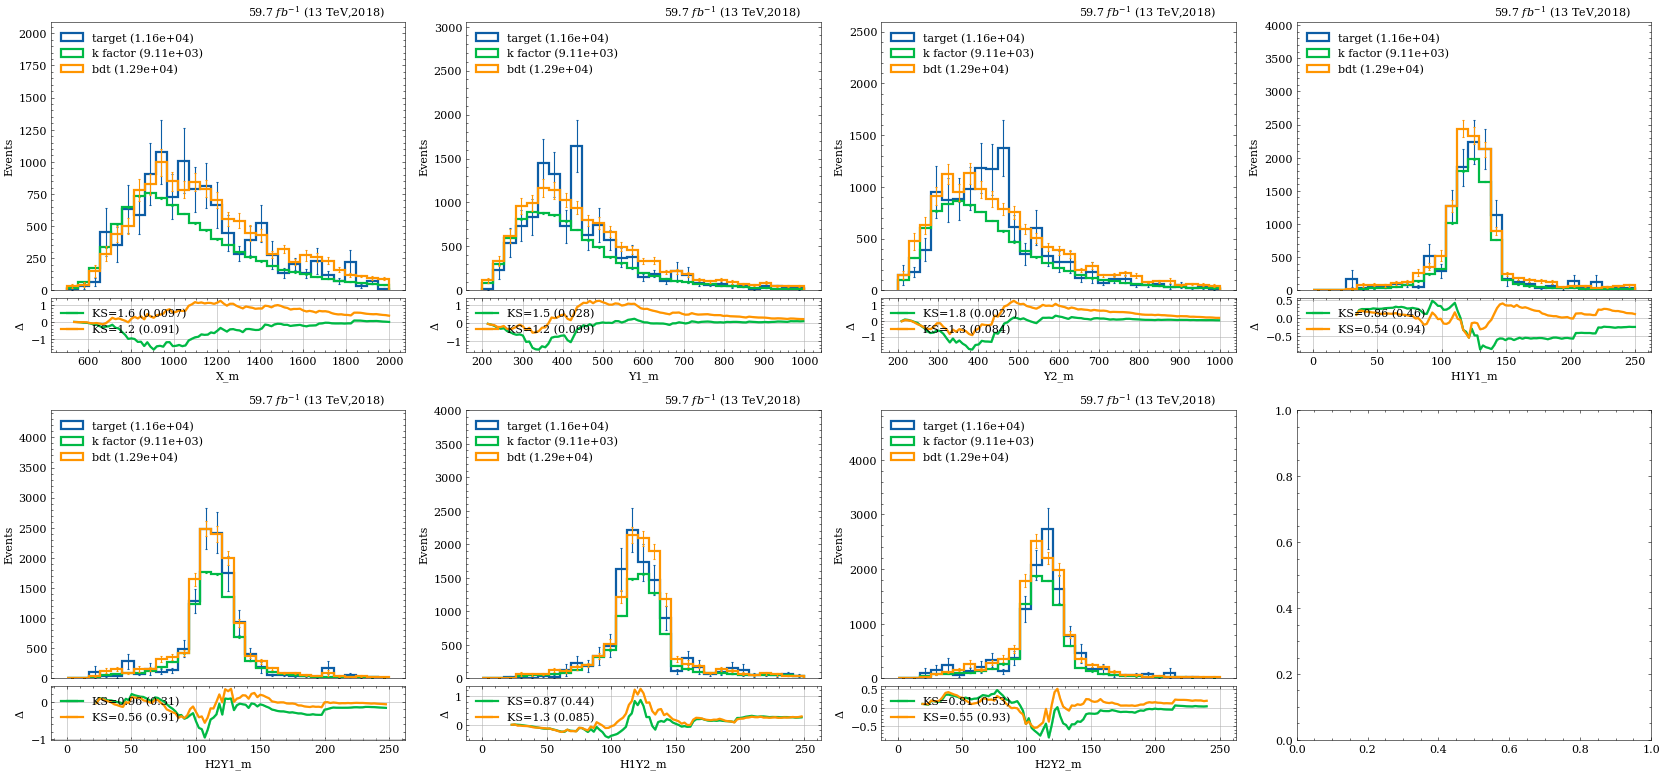

In [19]:
study.quick(
  data+data+data, h_color=None, label=['target','k factor','bdt'], legend=True,
  scale=[None, abcd.scale_tree, abcd.reweight_tree],
  masks=[abcd.a, abcd.b, abcd.b],
  dim=None,
  varlist=feature_names,


  empirical=True, e_show=False,
  e_difference=True,

)